# 📓 Notebook 2: Introduction to Decision Tree

In this notebook we will explore **Decision Trees**:

We will use **Taiwan Air Quality Index Data 2016~2024** to make predictions about air quality.


## 1. Initial Setup

We import the necessary libraries for:
- data manipulation (`pandas`, `numpy`)
- visualization (`matplotlib`)
- linear regression and evaluation metrics (`scikit-learn`)

We then load the dataset.


In [1]:
# Import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

cwd = 'drive/MyDrive/' # Set your current working directory where the csv file is located

# Check if file exists
file_path = cwd + 'es_python/air_quality.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The CSV file was not found at the path: {file_path}")

# Load dataset (first 1,000,000 rows for testing)
df = pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA','ND', 'n/a', ''], nrows=1000000)

Mounted at /content/drive


## 2. Data Cleaning  
Removal of completely empty columns. As already seen in Notebook 1.


In [2]:
df = df.dropna(axis=1, how='all')
df.dropna(subset='status', inplace=True)

## 3. Preprocess the Data

### Why Preprocessing?  
Data preprocessing is essential for cleaning and preparing data before feeding it into a machine learning model. In this step, we will:

- Select a meaningful set of features for our classification task.  
- Split the data into training and testing sets to fairly evaluate model performance.  
- Standardize the feature values using `StandardScaler` so they all share the same scale (mean = 0, variance = 1), which helps many machine learning algorithms converge faster and perform better.  

---

### What We'll Do:  
1. Select a set of informative features, including air pollutant levels, weather data, and time-based variables.  
2. Split the data into **training (70%)** and **testing (30%)** subsets.  
3. Apply **feature scaling** to all selected features so their values are standardized.


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Convert 'date' column to datetime and extract year
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Feature selection
features = [
    'pm2.5', 'pm10',
    'co', 'co_8hr',
    'no2', 'nox', 'no',
    'so2',
    'o3',
    'windspeed', 'winddirec',
    'year', 'longitude', 'latitude'
]
# Removed pm2.5_avg, pm10_avg --> features were too correlated with the target (remember Notebook 1) --> "target leakage"

### a. Group Labels
Let's check the class distribution.


In [4]:
print("\nCount per bin:")
print(df['status'].value_counts(dropna=False))


Count per bin:
status
Good                              636231
Moderate                          324939
Unhealthy for Sensitive Groups     34365
Unhealthy                           1707
Very Unhealthy                         3
Name: count, dtype: int64


Class are unbalanced, we could try to balance them by grouping less represented classes.


Chosen logic:

1. `poor` quality for Hazardous, Very Unhealthy, Unhealthy

2. `low but tolerable` quality for the general population

3. `moderate` quality

4. `good` quality

In [5]:
# Copy of the DataFrame to group the labels
df_group = df.copy()

In [6]:
# Conversion of categorical columns into numeric
df_group['status'] = df_group['status'].replace({
    "Hazardous": "Poor",
    "Very Unhealthy": "Poor",
    "Unhealthy": "Poor"
})

print("\nCount per bin:")
print(df_group['status'].value_counts(dropna=False))


Count per bin:
status
Good                              636231
Moderate                          324939
Unhealthy for Sensitive Groups     34365
Poor                                1710
Name: count, dtype: int64


### b. Split and Scale

In [7]:
X = df_group[features]
y = df_group['status']

# Split dataset
X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(
    X, y,
    test_size=0.3,   # 30% for test set and 70% for training set
    random_state=42  # for reproducibility
)

# Scaling
scaler = StandardScaler()
X_train_scaled_group = scaler.fit_transform(X_train_group)  # fit computes parameters (mean μ and std σ) only on training data
X_test_scaled_group  = scaler.transform(X_test_group)       # apply the μ and σ computed from training set

print("\nTraining set shape:", X_train_group.shape)
print("Testing set shape: ", X_test_group.shape)
print("Shapes after scaling:", X_train_scaled_group.shape, X_test_scaled_group.shape)


Training set shape: (698071, 14)
Testing set shape:  (299174, 14)
Shapes after scaling: (698071, 14) (299174, 14)


### Output Explanation:
- How to read the numbers: for example (626126, 14). The first number represents the number of rows (samples), the second the number of columns (features).
- We will use 30% of the dataset for the test set and 70% for the training set. The 70/30 split is a good compromise: enough data to train, enough data to reliably test.
- Training set (70% of the data): here the model is "trained"—it learns relationships between features and the target. The test set (30% of the data) remains hidden during training. It is used to evaluate performance on unseen data, simulating a real-world scenario.


## 4. Build and Evaluate the Model

**Why Decision Tree Classifier?**  
The Decision Tree is an intuitive and easily interpretable machine learning model. It handles well categorical data and can learn non-linear rules and interactions between features.

**What We'll Do:**
- Train a decision tree classifier on the preprocessed dataset.
- Use all selected features
- Evaluate the model using **Accuracy**, the percentage of correct predictions on the test set.
- Print a classification report to compare the model's performance across each class.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model_group = DecisionTreeClassifier(random_state=42)
model_group.fit(X_train_scaled_group, y_train_group)

# Predictions
y_pred_group = model_group.predict(X_test_scaled_group)

# Evaluation
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test_group, y_pred_group):.2f}")


Model Performance:
Accuracy: 0.84


## 5. Decision Tree Visualization and Model Evaluation

We used `plot_tree` to draw the model's decision tree, limiting it to a **maximum depth of 2** for better readability.

Here, a subset of the decision tree used to classify air quality is displayed. The decisions are based on variables like `pollutant`, `pm2.5_avg`, and `so2`. The nodes show:

- The split conditions
- The number of samples (`samples`)
- The Gini impurity index
- The most likely class at that node

This plot helps to understand **how the model makes its decisions**.


Features used: ['pm2.5', 'pm10', 'co', 'co_8hr', 'no2', 'nox', 'no', 'so2', 'o3', 'windspeed', 'winddirec', 'year', 'longitude', 'latitude']


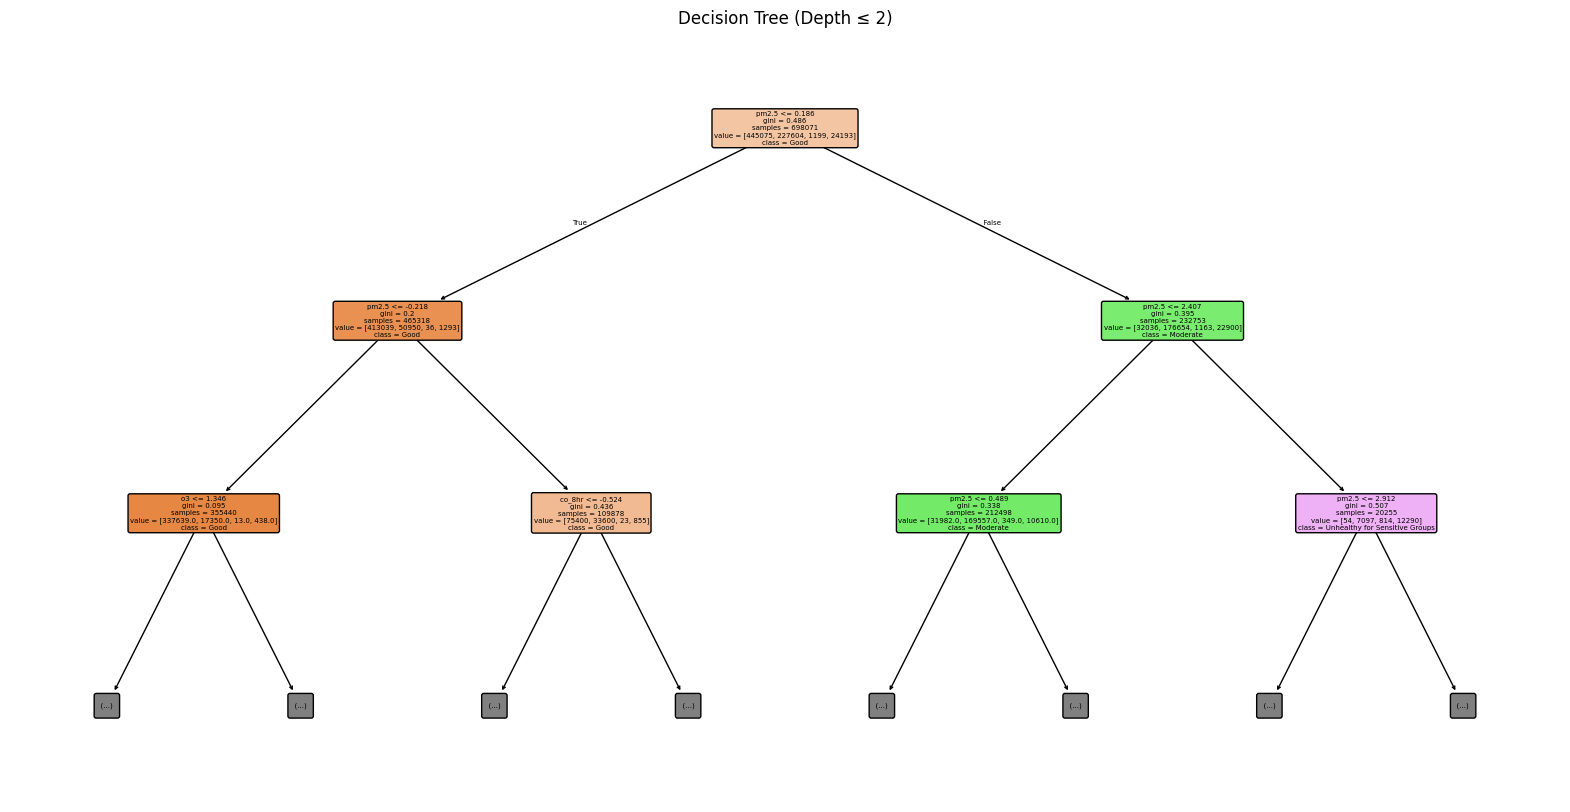

In [9]:
print("Features used:", X.columns.tolist())

plt.figure(figsize=(20, 10))
plot_tree(
    model_group,
    max_depth=2,
    feature_names=X.columns,
    class_names=[str(cls) for cls in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=5  # increase the text size in the nodes
)
plt.title("Decision Tree (Depth ≤ 2)")
plt.show()

The full decision tree is depicted below.

### Confusion Matrix

The **confusion matrix** shows the model's performance on its predictions.

- The model performs very well on class `Good`, and has decent precision on class `Moderate`.


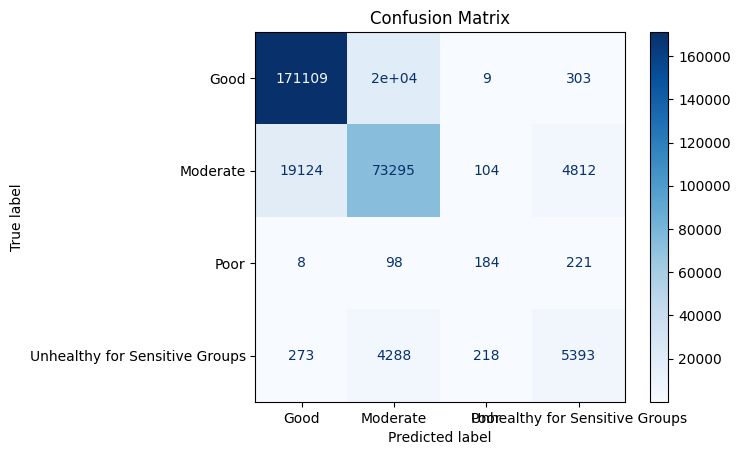

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test_group, y_pred_group)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Exercise 1

Build and analyse the tree considering the original dataset, considering all the 6 classes.

In [11]:
# Copy of the original DataFrame
df_ex1 = df.copy()

# Select only columns from features
X_ex1 = df_ex1[features]
y_ex1 = df_ex1['status']


Model accuracy
accuracy: 0.84
[[171109  19124      8    273      0]
 [ 19735  73295     97   4288      1]
 [     9    104    184    218      0]
 [   303   4812    220   5393      1]
 [     0      0      0      0      0]]


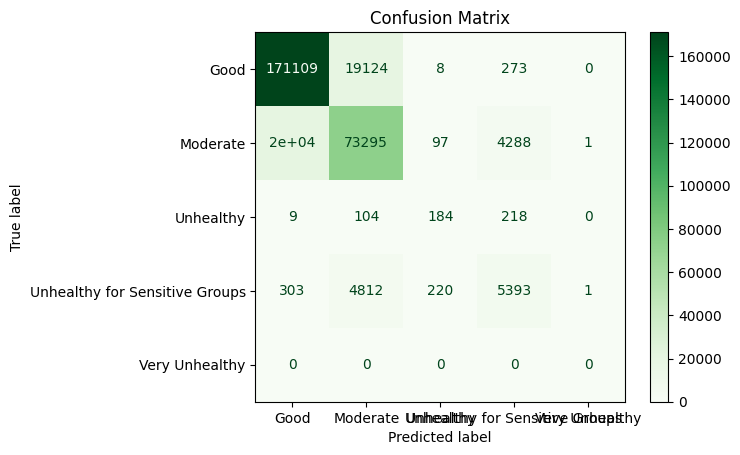

In [17]:
# Split dataset starting from X_ex1 and y_ex1. Remember to set random_state=42
from sklearn.model_selection import train_test_split
X_ex1_train,X_ex1_test,y_ex1_train,y_ex1_test=train_test_split(X_ex1,y_ex1,test_size=0.3,random_state=42)
# Scaling
#Il metodo fit() impara questi parametri (μ e σ) dai dati su cui è eseguito, lo faccio solo sui dati di training
#transform mi scala i dati (fra 0 e 1)
scaler=StandardScaler()
X_ex1_scaled_train=scaler.fit_transform(X_ex1_train)
X_ex1_scaled_test=scaler.transform(X_ex1_test)

# Initialize and train the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
model_ex1=DecisionTreeClassifier(random_state=42)
model_ex1.fit(X_ex1_scaled_train,y_ex1_train)

# Predictions
y_ex1_pred=model_ex1.predict(X_ex1_scaled_test)

# Evaluation
print("\nModel accuracy")
accuracy=accuracy_score(y_ex1_pred,y_ex1_test)
print(f"accuracy: {accuracy:.2f}")

conf=confusion_matrix(y_ex1_pred,y_ex1_test)
print(conf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=sorted(y_ex1.unique()))
disp.plot(cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

### Solution


Training set shape: (698071, 14)
Testing set shape:  (299174, 14)
Shapes after scaling: (698071, 14) (299174, 14)

Model Performance:
Accuracy: 0.84


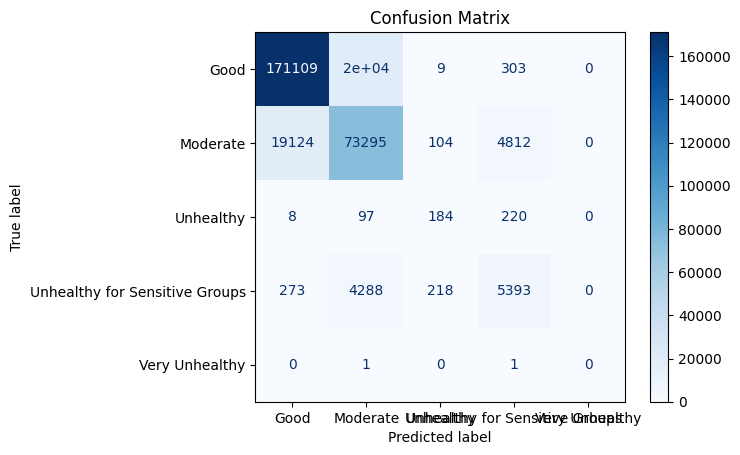

In [ ]:
# Split dataset starting from X_ex1 and y_ex1. Remember to set random_state=42
X_train_ex1, X_test_ex1, y_train_ex1, y_test_ex1 = train_test_split(
    X_ex1, y_ex1,
    test_size=0.3,   # 30% for test set and 70% for training set
    random_state=42  # for reproducibility
)

# Scaling
scaler = StandardScaler()
X_train_scaled_ex1 = scaler.fit_transform(X_train_ex1)  # fit computes parameters (mean μ and std σ) only on training data
X_test_scaled_ex1  = scaler.transform(X_test_ex1)       # apply the μ and σ computed from training set

print("\nTraining set shape:", X_train_ex1.shape)
print("Testing set shape: ", X_test_ex1.shape)
print("Shapes after scaling:", X_train_scaled_ex1.shape, X_test_scaled_ex1.shape)

# Initialize and train the model
model_ex1 = DecisionTreeClassifier(random_state=42)
model_ex1.fit(X_train_scaled_ex1, y_train_ex1)

# Predictions
y_pred_ex1 = model_ex1.predict(X_test_scaled_ex1)

# Evaluation
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test_ex1, y_pred_ex1):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_ex1, y_pred_ex1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_ex1.unique()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Exercise 2

Use LabelEncoder to encode county and sitename. Than train a new Random Tree (use the same random_state) to check if the results are changed

In [13]:
# Copy of the original DataFrame
df_ex2 = df.copy()


Model Performance:
[[171109  19735      9    303      0]
 [ 19124  73295    104   4812      0]
 [     8     97    184    220      0]
 [   273   4288    218   5393      0]
 [     0      1      0      1      0]]


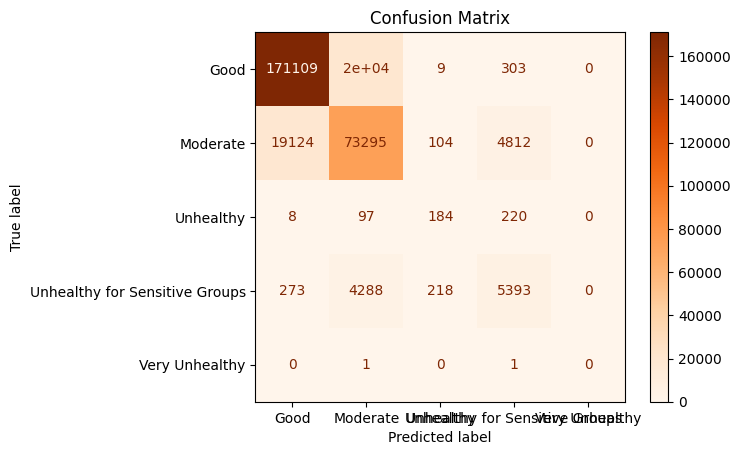

In [16]:
# import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Encode of county
label_county=LabelEncoder()
df_ex2["county"]=df_ex2["county"].astype(str)
df_ex2["county"]=label_county.fit_transform(df_ex2["county"])

# Encode of sitename
label_sitename=LabelEncoder()
df_ex2["sitename"]=df_ex2["sitename"].astype(str)
df_ex2["sitename"]=label_sitename.fit_transform(df_ex2["sitename"])

# Select only columns from features
X_ex2 = df_ex2[features]
y_ex2 = df_ex2['status']

# Split dataset starting from X_ex2 and y_ex2. Remember to set random_state=42
X_train_es2,X_test_es2,y_train_es2,y_test_es2=train_test_split(X_ex2,y_ex2,test_size=0.3,random_state=42)

# Scaling
scaler=StandardScaler()
X_train_scaled_es2=scaler.fit_transform(X_train_es2)
X_test_scaled_es2=scaler.transform(X_test_es2)

# Initialize and train the model
model=DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled_es2,y_train_es2)

# Predictions
y_pred_es2=model.predict(X_test_scaled_es2)

# Evaluation
print("\nModel Performance:")
accuracy=accuracy_score(y_test_es2,y_pred_es2)

# Confusion Matrix
conf=confusion_matrix(y_test_es2,y_pred_es2)
print(conf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=sorted(y_ex2.unique()))
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix")
plt.show()


### Solution

          status  county  sitename
0       Moderate       5        40
1           Good      15        79
2           Good       5        81
3           Good       3         4
4           Good       8        51
...          ...     ...       ...
999995  Moderate       2        88
999996  Moderate       4        26
999997  Moderate       4        25
999998  Moderate       4        83
999999  Moderate       4        60

[997245 rows x 3 columns]

Training set shape: (698071, 14)
Testing set shape:  (299174, 14)
Shapes after scaling: (698071, 14) (299174, 14)

Model Performance:
Accuracy: 0.84


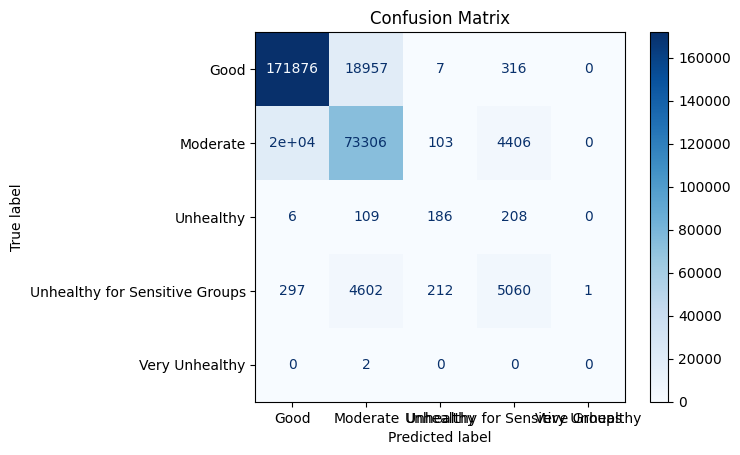

In [ ]:
# import LabelEncoder
from sklearn.preprocessing import LabelEncoder  # Automatic with LabelEncoder

# Encode of county
le_county = LabelEncoder()
df_ex2["county"] = le_county.fit_transform(df_ex2["county"].astype(str))

# Encode of sitename
le_sitename = LabelEncoder()
df_ex2["sitename"] = le_sitename.fit_transform(df_ex2["sitename"].astype(str))

print(df_ex2[['status', 'county', 'sitename']])

# Select only columns from features
X_ex2 = df_ex2[features]
y_ex2 = df_ex2['status']

# Split dataset starting from X and y (not y_group). Remember to set random_state=42
X_train_ex2, X_test_ex2, y_train_ex2, y_test_ex2 = train_test_split(
    X_ex2, y_ex2,
    test_size=0.3,   # 30% for test set and 70% for training set
    random_state=42  # for reproducibility
)

# Scaling
scaler = StandardScaler()
X_train_scaled_ex2 = scaler.fit_transform(X_train_ex2)  # fit computes parameters (mean μ and std σ) only on training data
X_test_scaled_ex2  = scaler.transform(X_test_ex2)       # apply the μ and σ computed from training set

print("\nTraining set shape:", X_train_ex2.shape)
print("Testing set shape: ", X_test_ex2.shape)
print("Shapes after scaling:", X_train_scaled_ex2.shape, X_test_scaled_ex2.shape)

# Initialize and train the model
model_ex2 = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_ex2.fit(X_train_scaled_ex2, y_train_ex2)

# Predictions
y_pred_ex2 = model_ex2.predict(X_test_scaled_ex2)

# Evaluation
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test_ex2, y_pred_ex2):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_ex2, y_pred_ex2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_ex2.unique()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## Exercise 3
Try with different test sizes

### Exercise 3.a: Setting Parameters for the Analysis
We set:
- a range of tree depths (`max_depth`)
- different values of `test_size` from 0.2 to 0.8 in steps of 0.1



In [15]:
import numpy as np
min_depth = 2
max_depth = 10
test_sizes = np.array([0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80])
accuracy_list_list = []
size_list = []

# To make faster the execution we reduce the dataset to the first 900 rows
X = X.head(900)
y = y.head(900)

### Exercise 3.b: Loop over test_size and Tree Depth
For each combination of test_sizes and tree_depth:
1. create a new split using tst_sizes (consider X and y from previous code cells),
2. normalize the data,
3. train a Random Tree saving its accuracy in the array accuracy_list,
4. append accuracy_list into accuracy_list_list.

Finally, plot accuracy vs max_depth for different test_size values (all in the same plot, drawing a line for each different size)



['Good', 'Moderate']
['Good', 'Moderate', 'Unhealthy for Sensitive Groups']

Model Performance:
Accuracy: 0.84


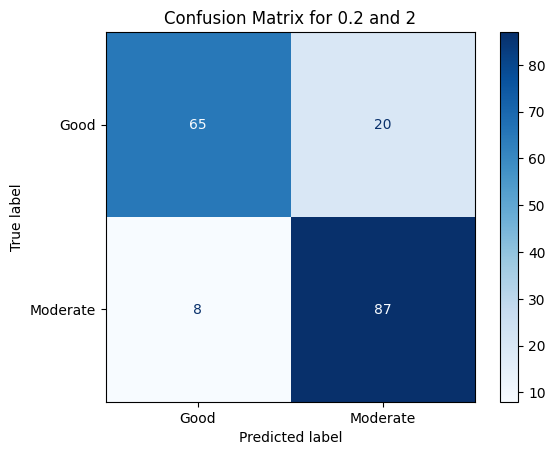


Model Performance:
Accuracy: 0.84


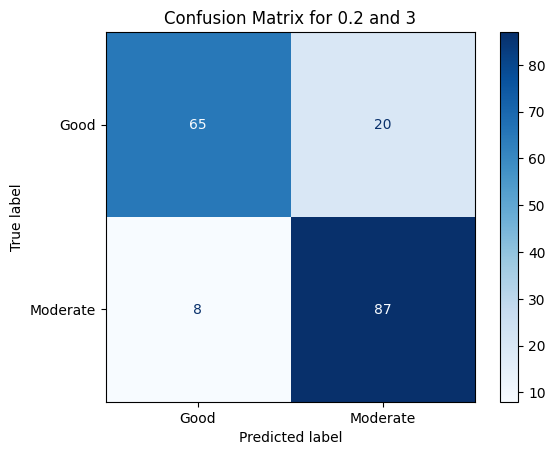


Model Performance:
Accuracy: 0.84


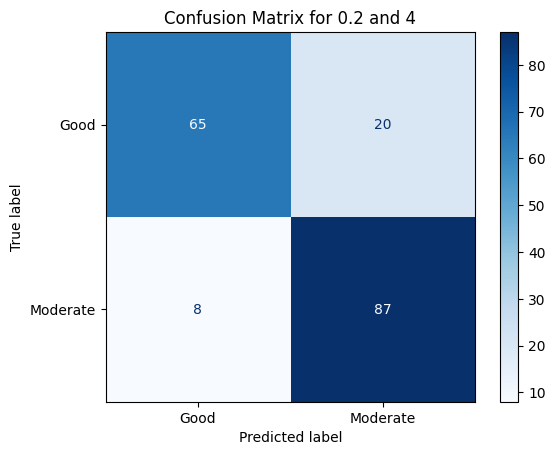


Model Performance:
Accuracy: 0.84


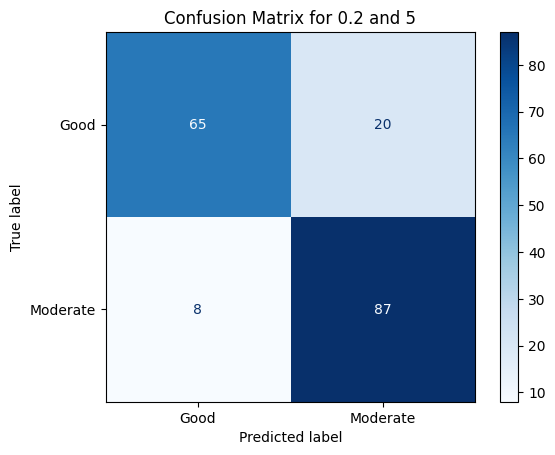


Model Performance:
Accuracy: 0.84


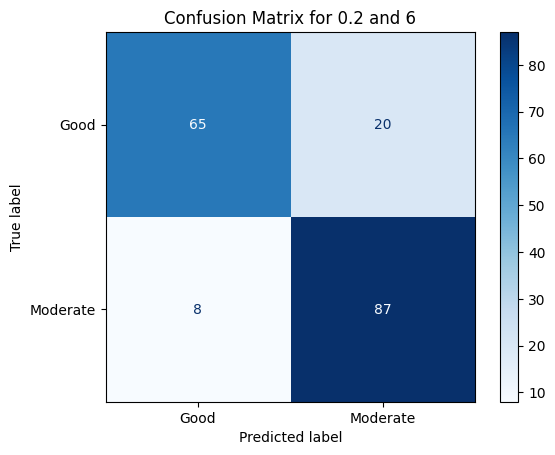


Model Performance:
Accuracy: 0.84


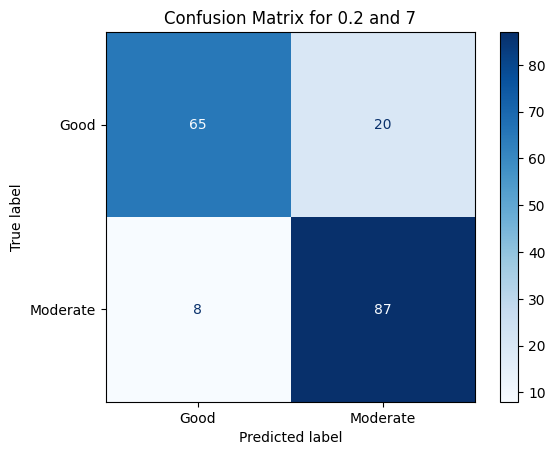


Model Performance:
Accuracy: 0.84


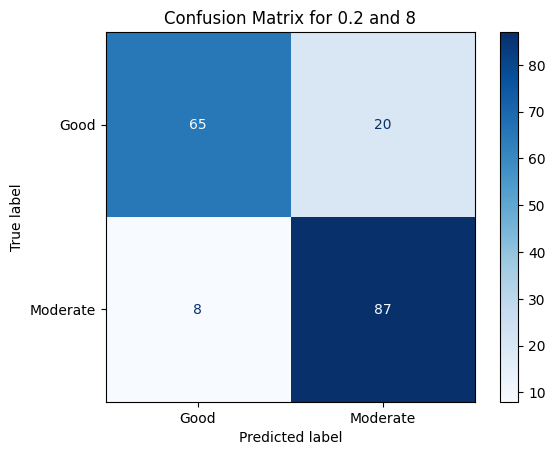


Model Performance:
Accuracy: 0.84


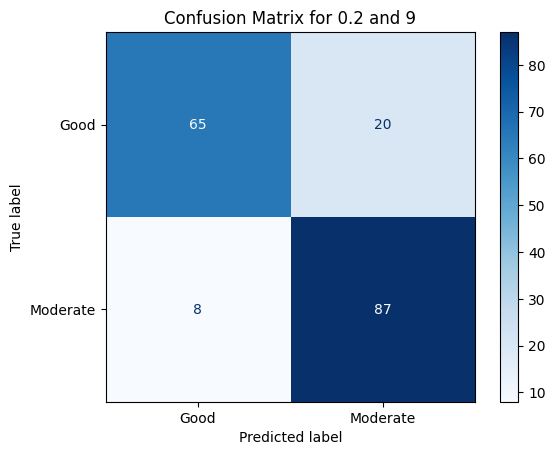

['Good', 'Moderate']
['Good', 'Moderate', 'Unhealthy for Sensitive Groups']

Model Performance:
Accuracy: 0.83


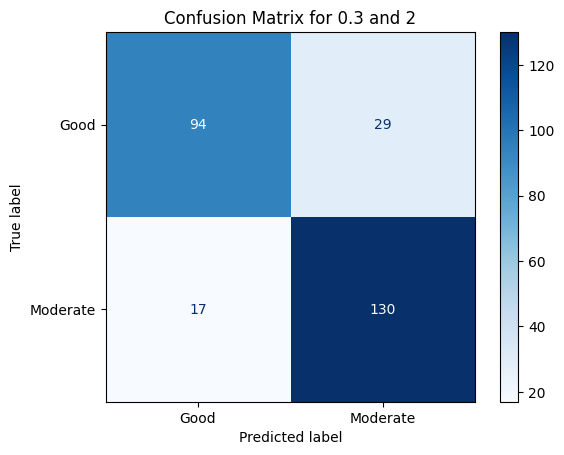


Model Performance:
Accuracy: 0.83


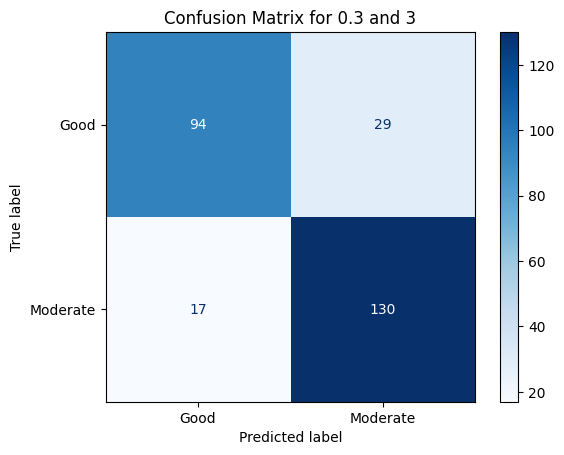


Model Performance:
Accuracy: 0.83


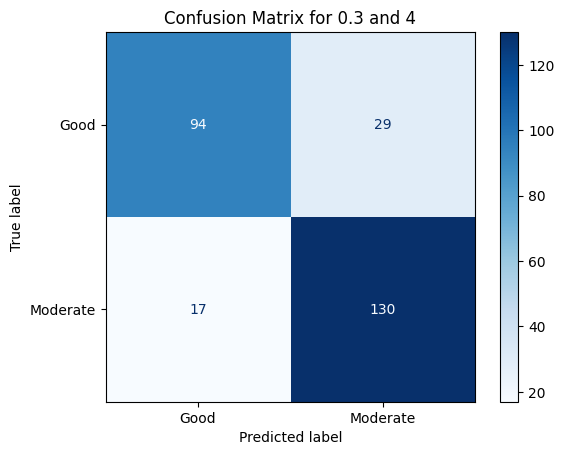


Model Performance:
Accuracy: 0.83


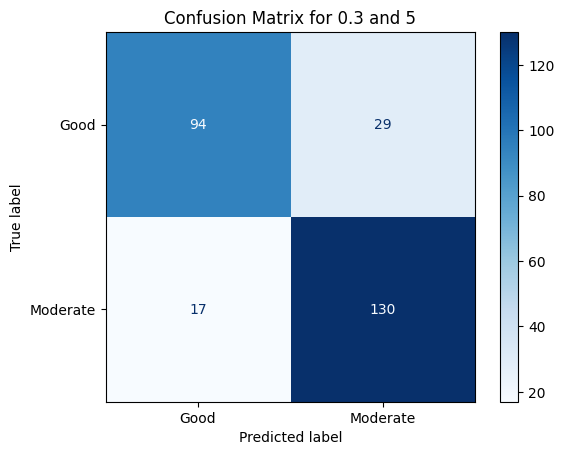


Model Performance:
Accuracy: 0.83


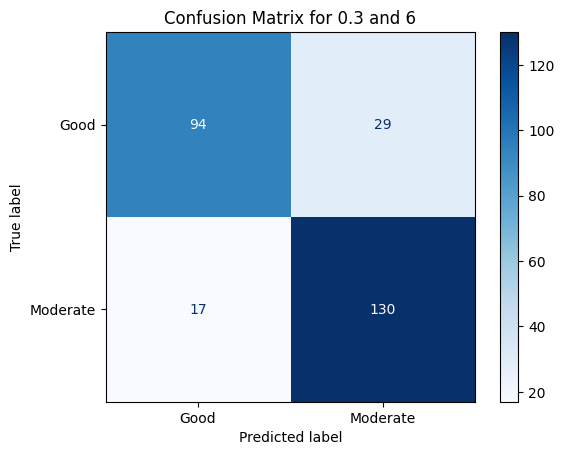


Model Performance:
Accuracy: 0.83


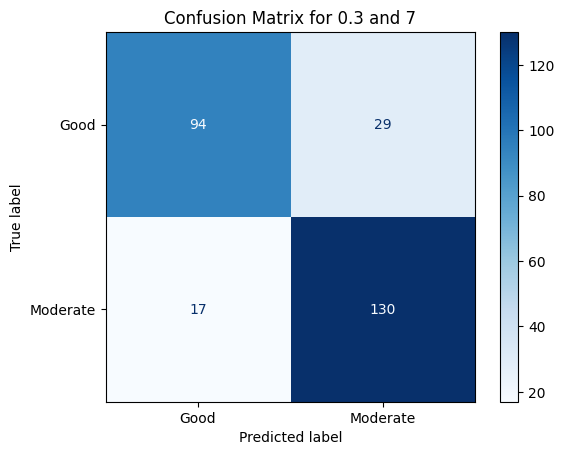


Model Performance:
Accuracy: 0.83


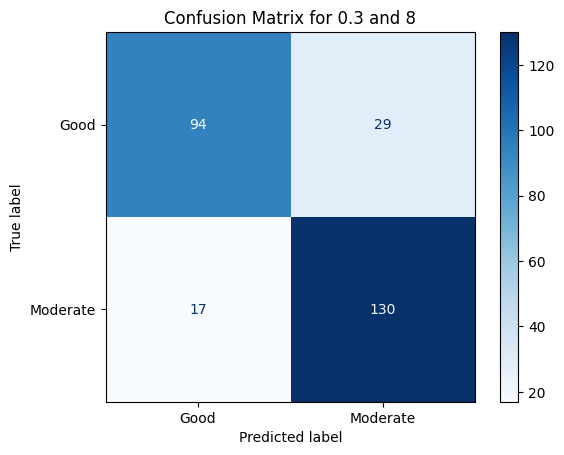


Model Performance:
Accuracy: 0.83


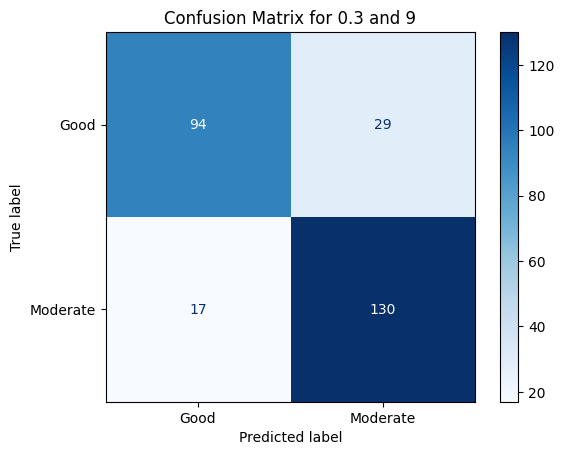

['Good', 'Moderate', 'Unhealthy for Sensitive Groups']
['Good', 'Moderate', 'Unhealthy for Sensitive Groups']

Model Performance:
Accuracy: 0.81


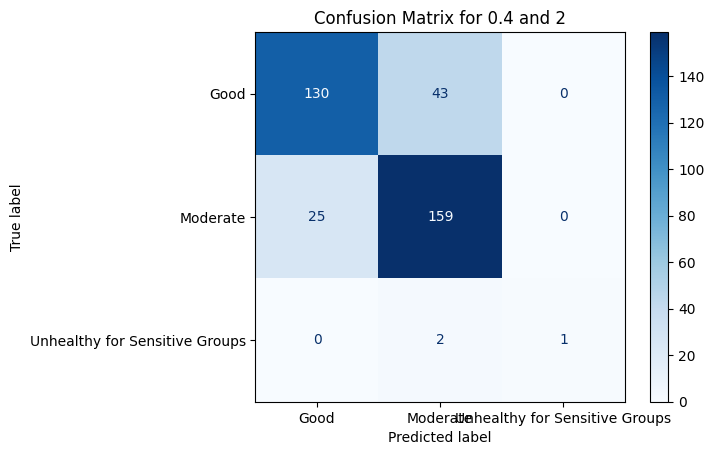


Model Performance:
Accuracy: 0.81


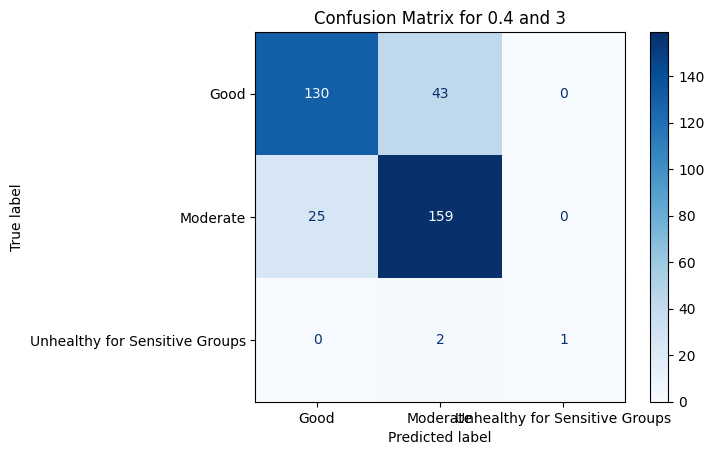


Model Performance:
Accuracy: 0.81


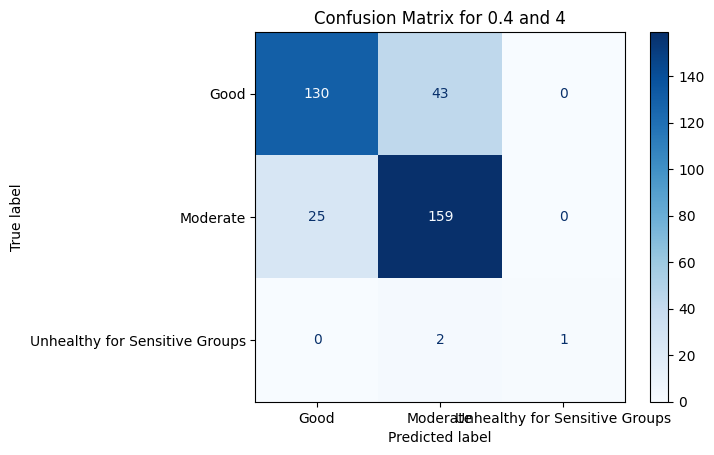


Model Performance:
Accuracy: 0.81


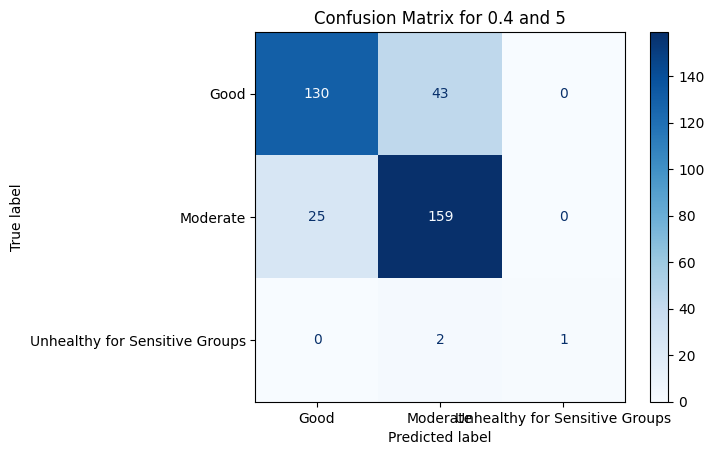


Model Performance:
Accuracy: 0.81


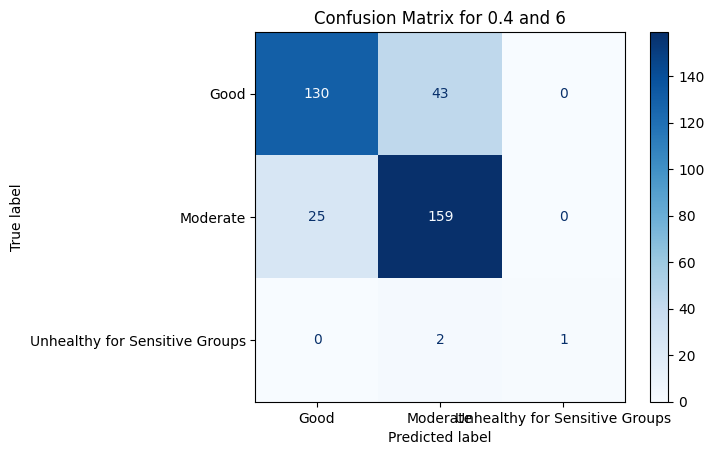


Model Performance:
Accuracy: 0.81


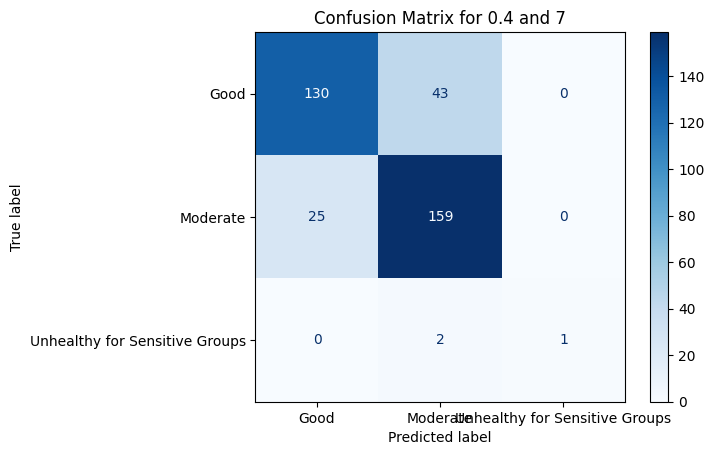


Model Performance:
Accuracy: 0.81


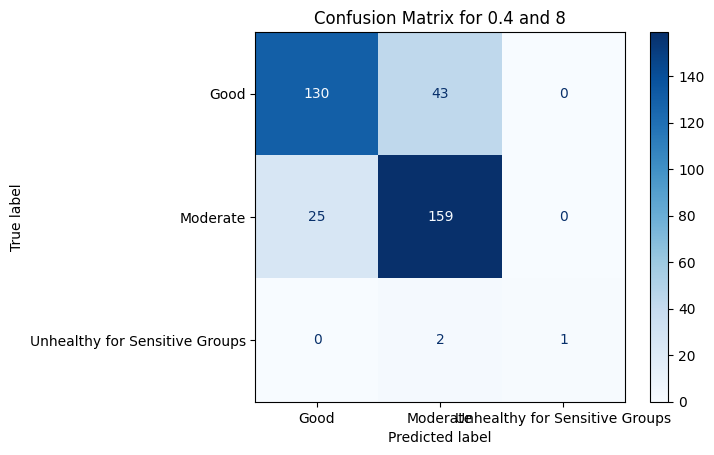


Model Performance:
Accuracy: 0.81


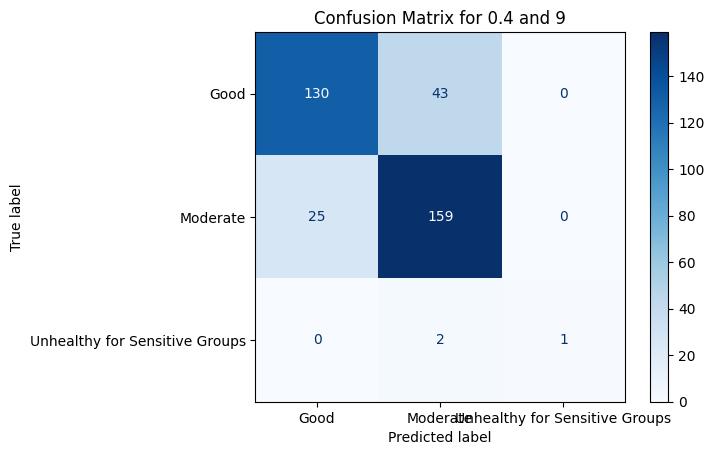

['Good', 'Moderate', 'Unhealthy for Sensitive Groups']
['Good', 'Moderate', 'Unhealthy for Sensitive Groups']

Model Performance:
Accuracy: 0.77


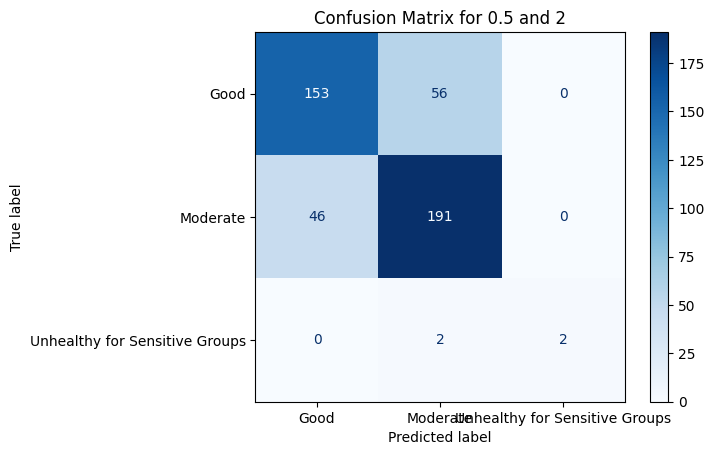


Model Performance:
Accuracy: 0.77


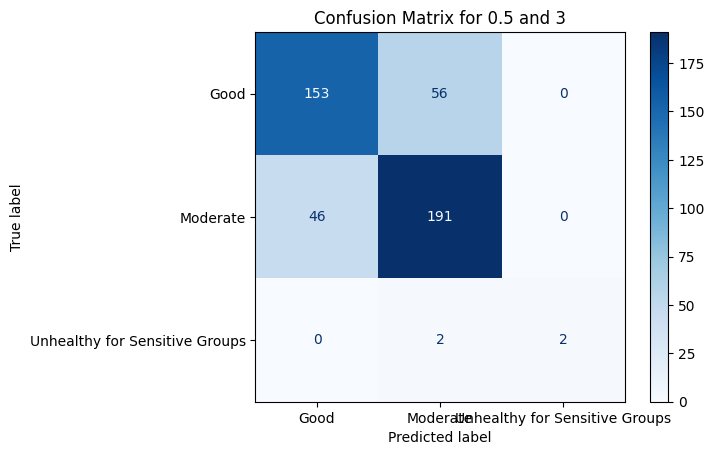


Model Performance:
Accuracy: 0.77


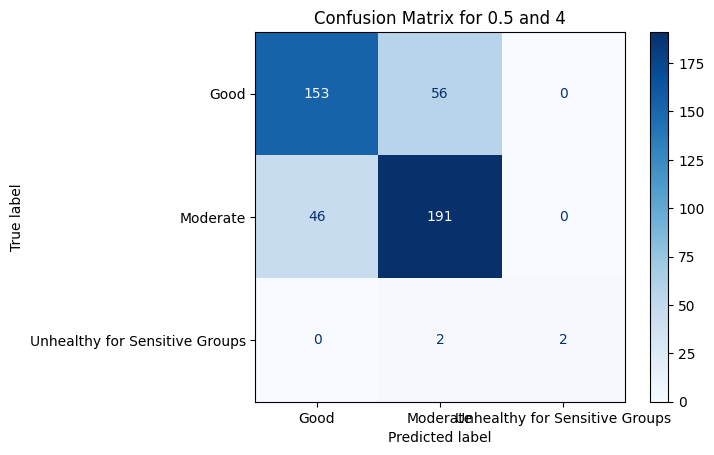


Model Performance:
Accuracy: 0.77


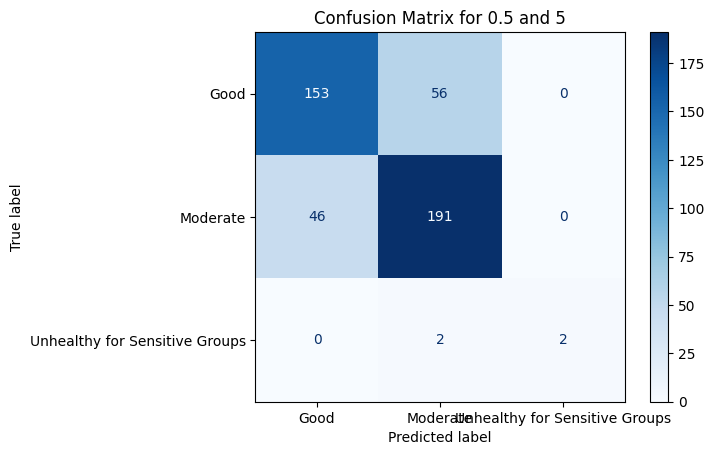


Model Performance:
Accuracy: 0.77


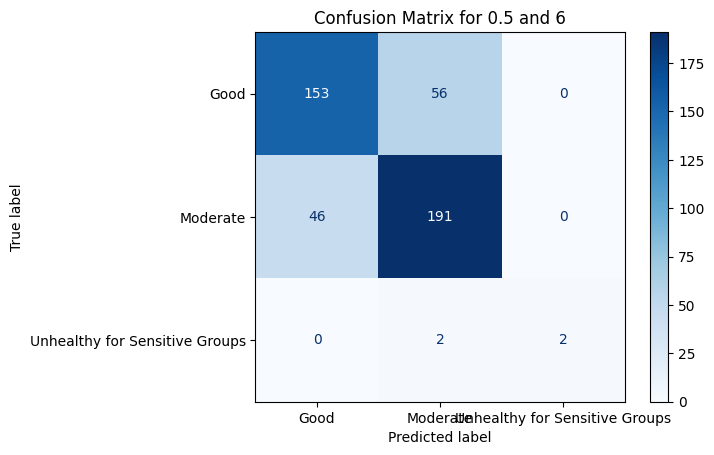


Model Performance:
Accuracy: 0.77


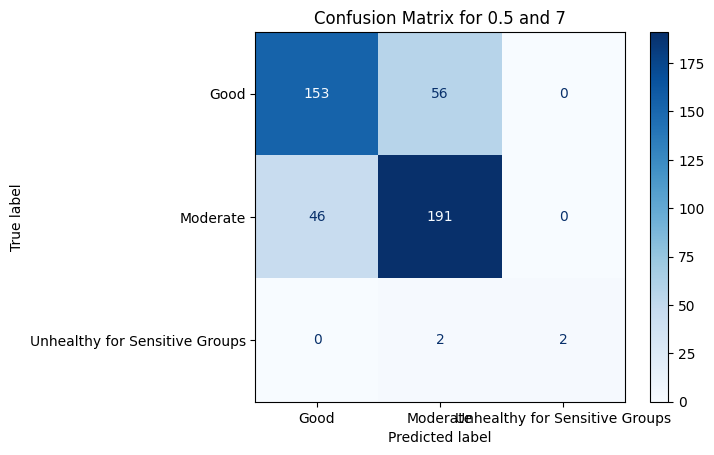


Model Performance:
Accuracy: 0.77


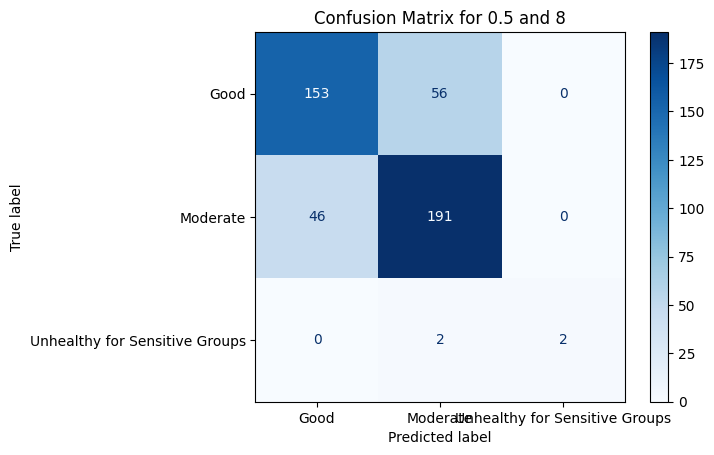


Model Performance:
Accuracy: 0.77


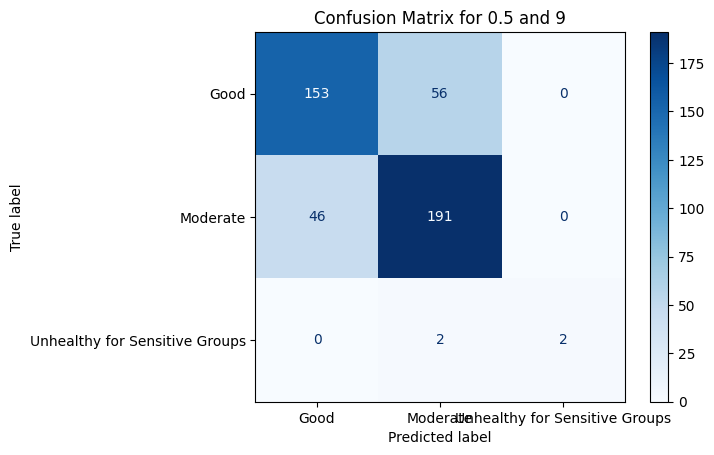

['Good', 'Moderate', 'Unhealthy for Sensitive Groups']
['Good', 'Moderate', 'Unhealthy for Sensitive Groups']

Model Performance:
Accuracy: 0.76


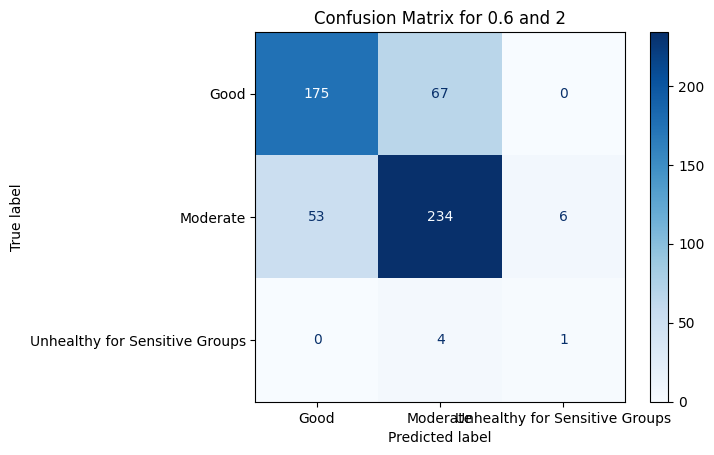


Model Performance:
Accuracy: 0.76


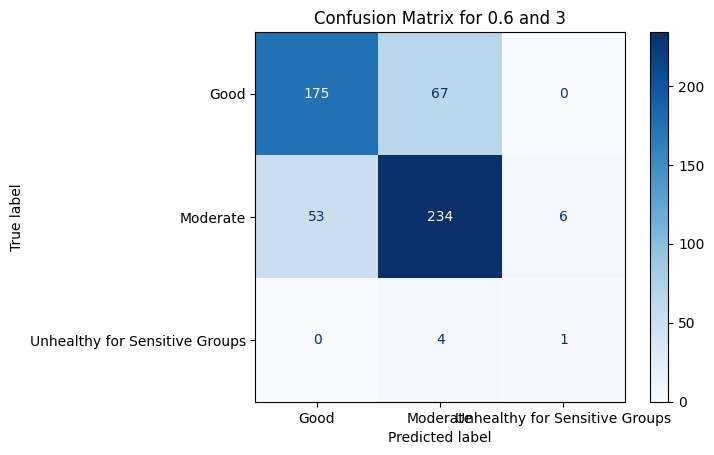


Model Performance:
Accuracy: 0.76


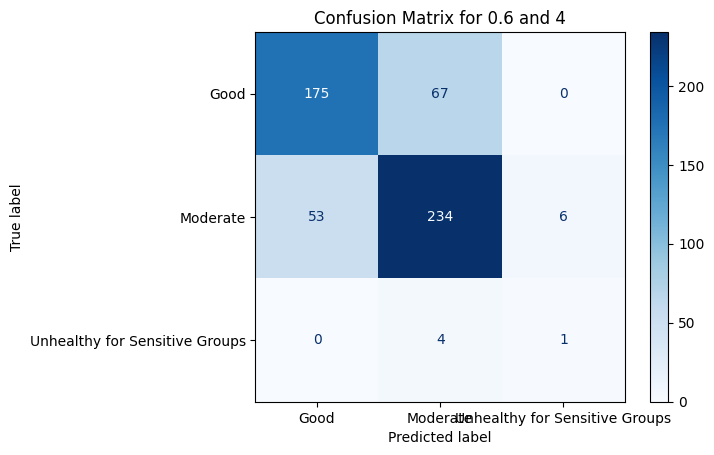


Model Performance:
Accuracy: 0.76


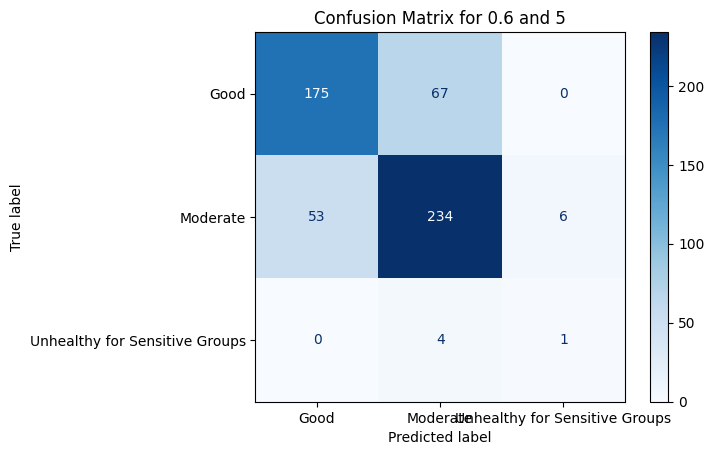


Model Performance:
Accuracy: 0.76


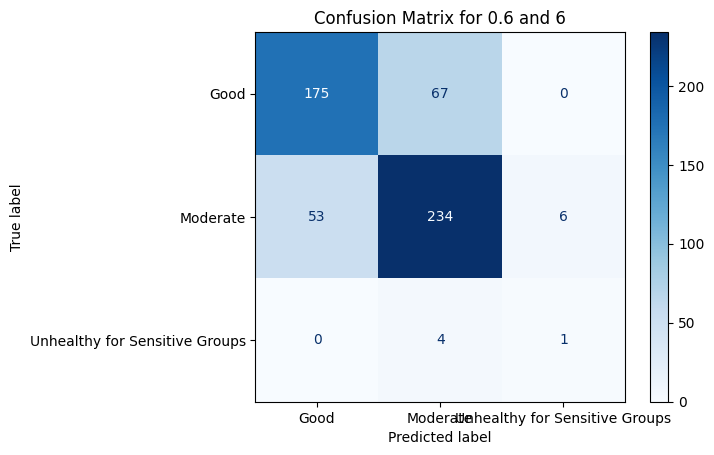


Model Performance:
Accuracy: 0.76


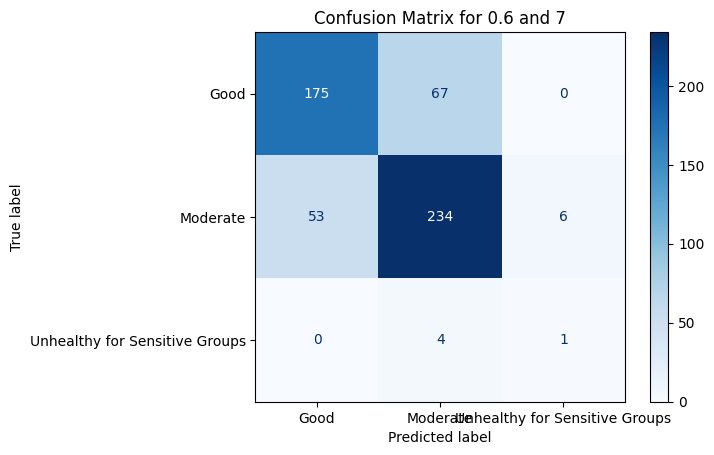


Model Performance:
Accuracy: 0.76


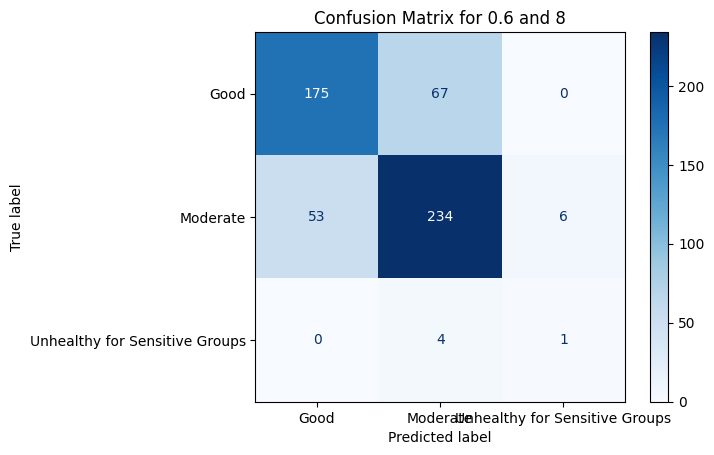


Model Performance:
Accuracy: 0.76


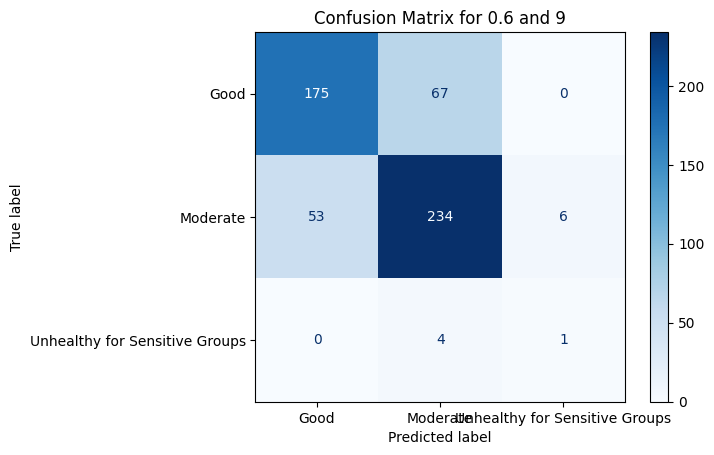

['Good', 'Moderate', 'Unhealthy for Sensitive Groups']
['Good', 'Moderate', 'Unhealthy for Sensitive Groups']

Model Performance:
Accuracy: 0.78


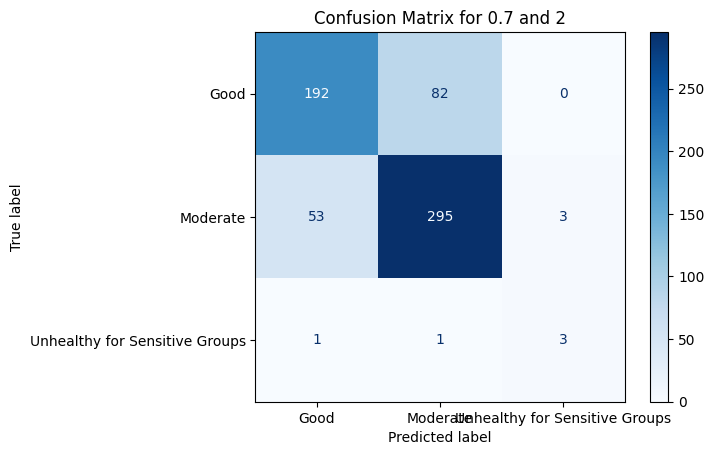


Model Performance:
Accuracy: 0.78


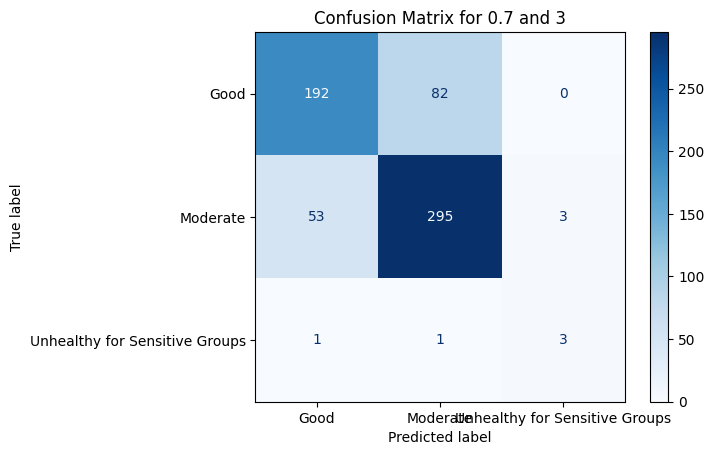


Model Performance:
Accuracy: 0.78


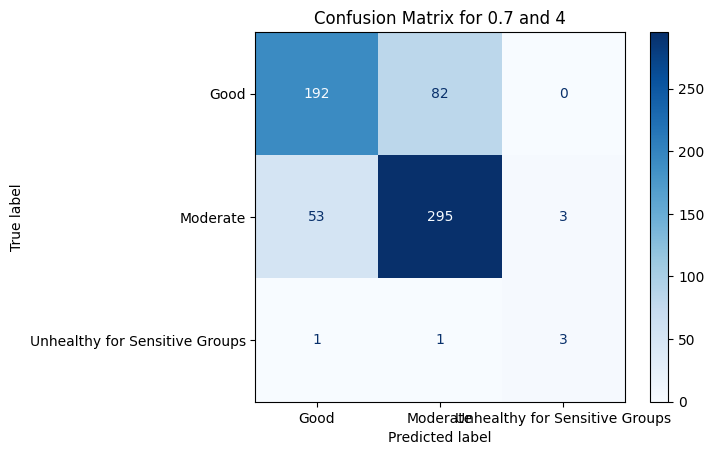


Model Performance:
Accuracy: 0.78


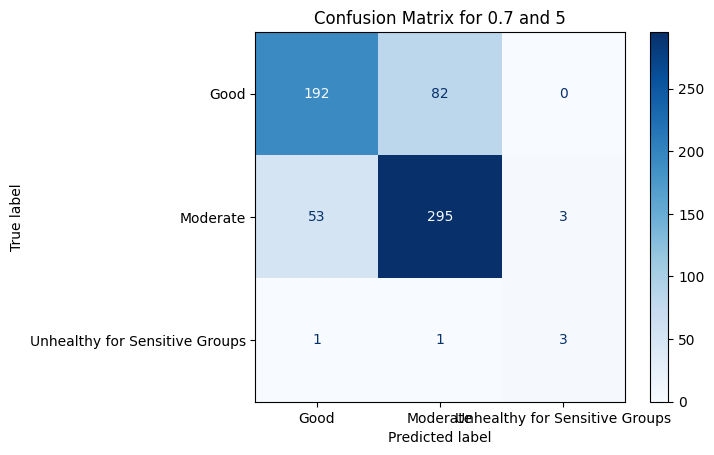


Model Performance:
Accuracy: 0.78


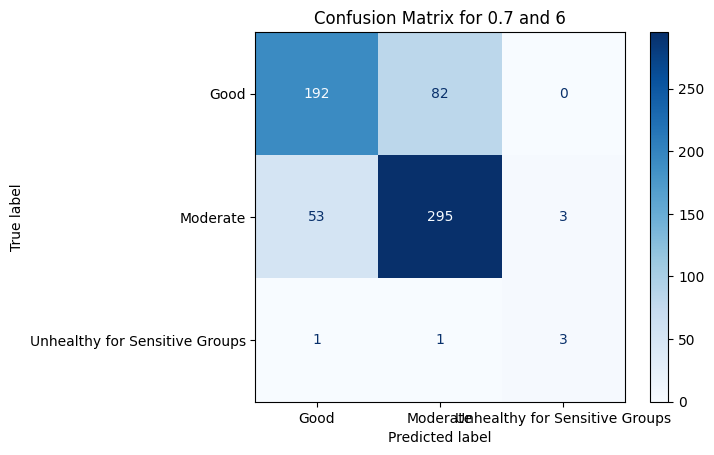


Model Performance:
Accuracy: 0.78


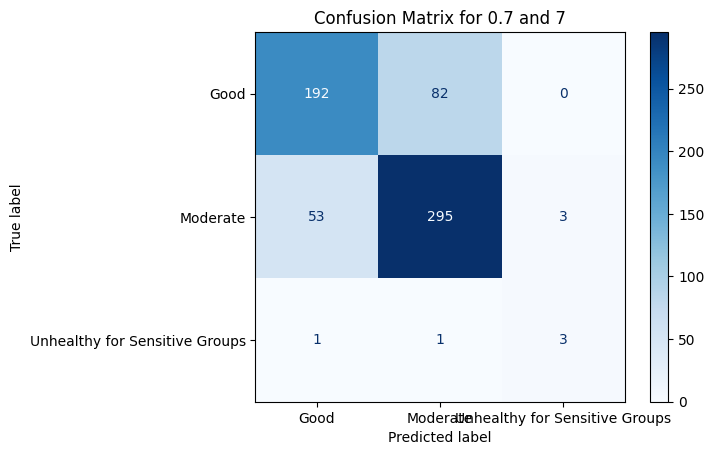


Model Performance:
Accuracy: 0.78


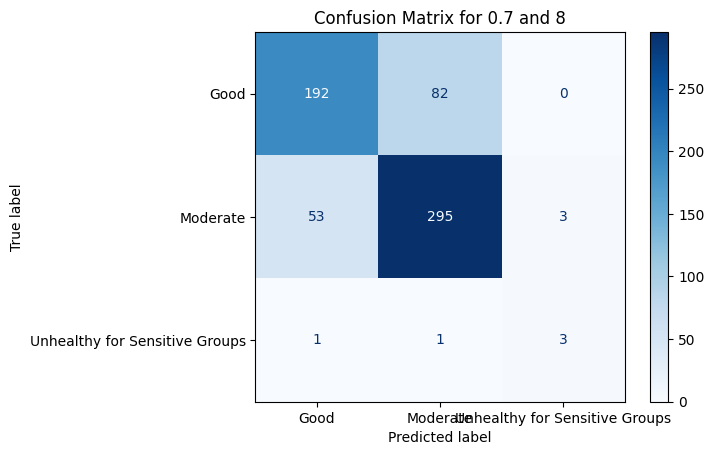


Model Performance:
Accuracy: 0.78


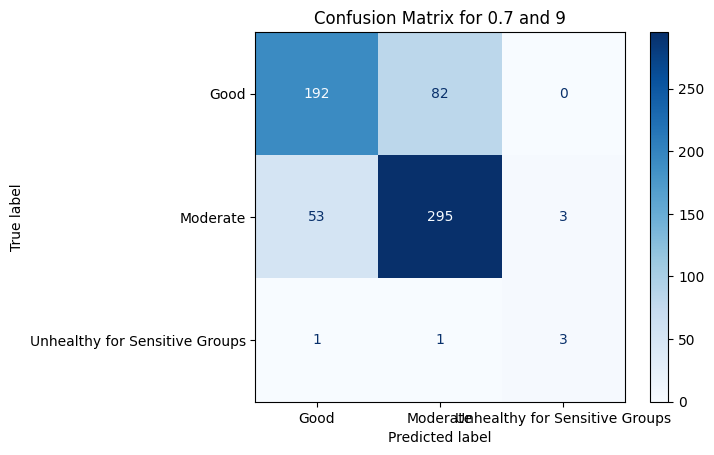

['Good', 'Moderate', 'Unhealthy for Sensitive Groups']
['Good', 'Moderate', 'Unhealthy for Sensitive Groups']

Model Performance:
Accuracy: 0.78


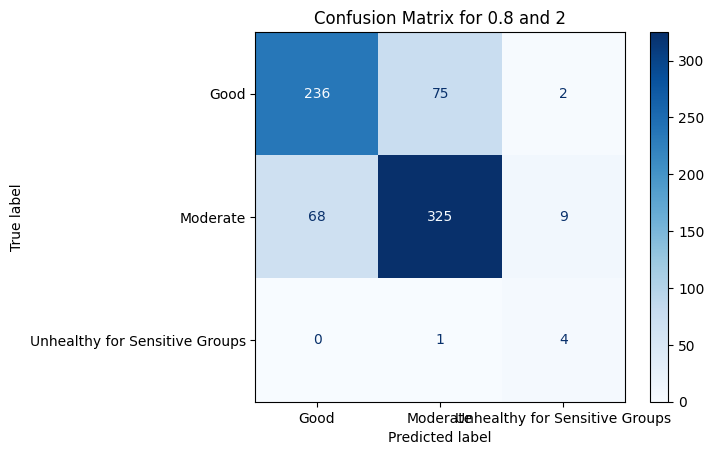


Model Performance:
Accuracy: 0.78


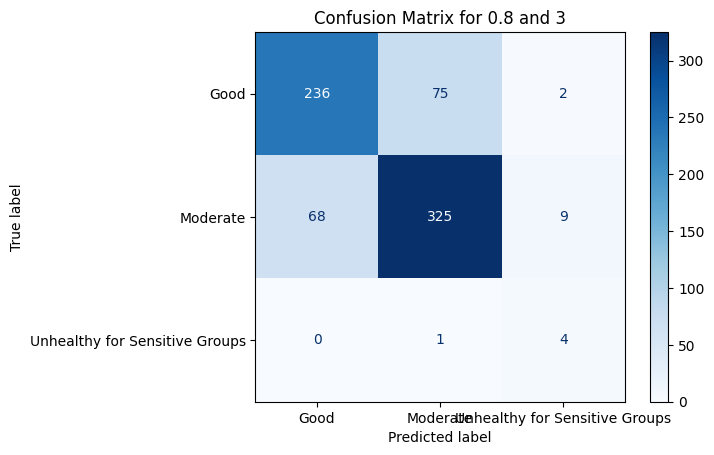


Model Performance:
Accuracy: 0.78


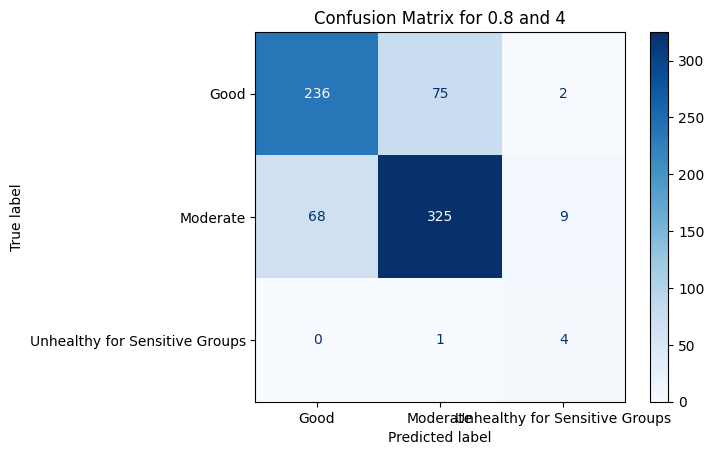


Model Performance:
Accuracy: 0.78


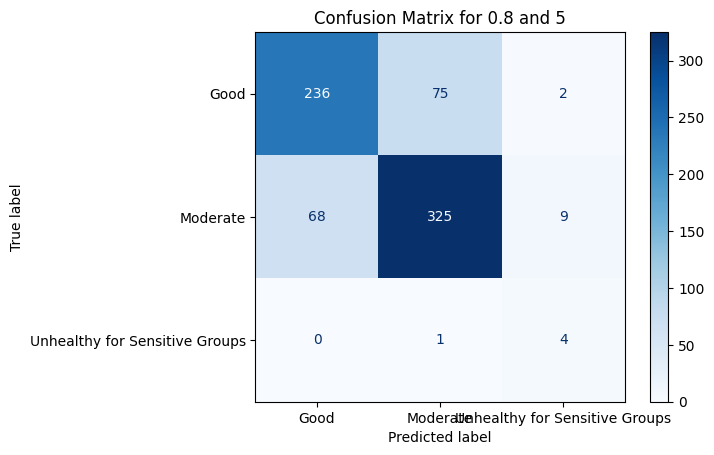


Model Performance:
Accuracy: 0.78


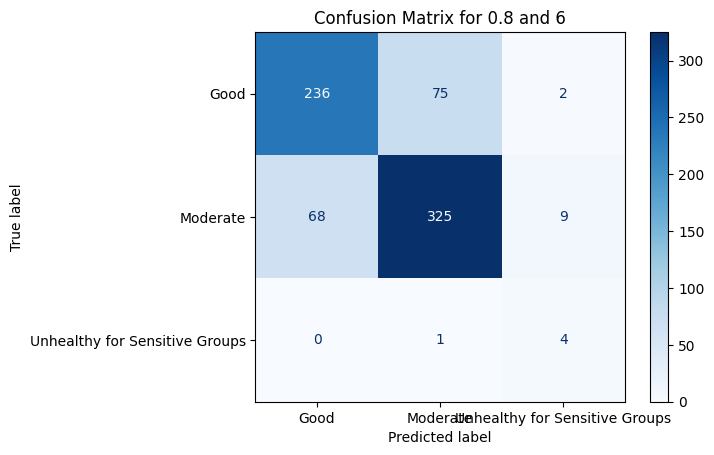


Model Performance:
Accuracy: 0.78


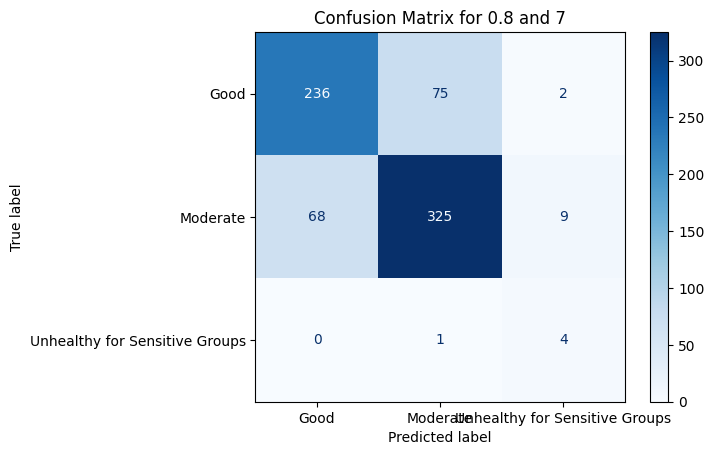


Model Performance:
Accuracy: 0.78


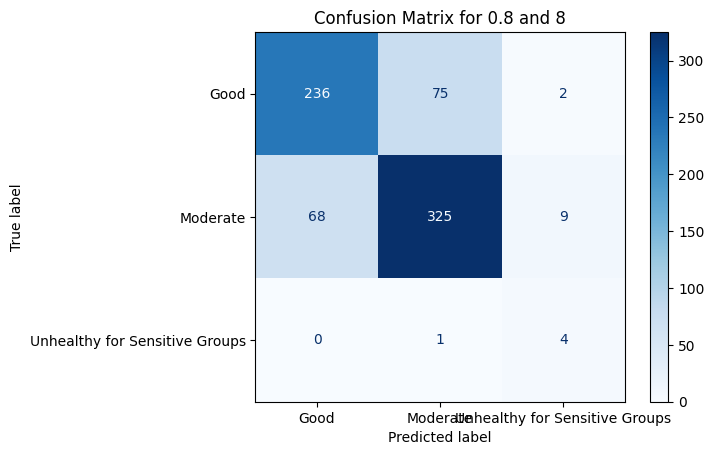


Model Performance:
Accuracy: 0.78


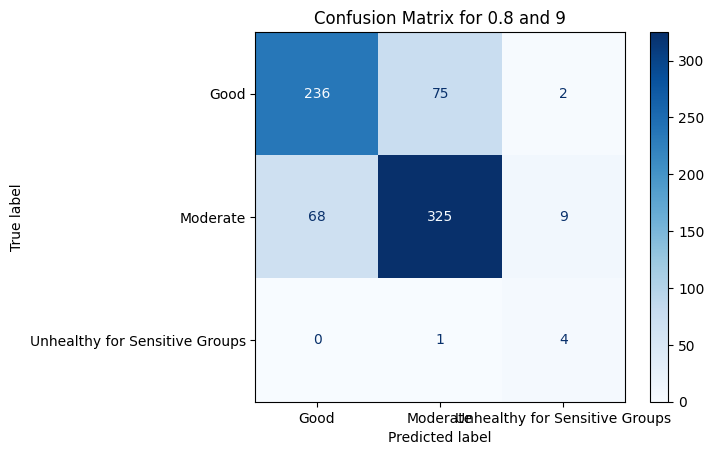

In [22]:
# for each test_size in test_sizes:
for size in test_sizes:
    size_list.append(size)
    # Split the dataset
    x_ex3_train,x_ex3_test,y_ex3_train,y_ex3_test=train_test_split(X,y,test_size=size,random_state=42)

    # Scaling
    scaler=StandardScaler()
    x_ex3_train_scaled=scaler.fit_transform(x_ex3_train)
    x_ex3_test_scaled=scaler.transform(x_ex3_test)
    # Standardization

    #vedo che nella parte di test manca una etichetta (dataset sbilanciato mal rappresentato)
    print(sorted(np.unique(y_ex3_test)))  # Controlla le etichette uniche nel test set
    print(sorted(y.unique()))  # Controlla le etichette uniche in tutto il dataset

    # List of accuracies for increasing tree depths
    accuracy_list = [] #<- uncomment this
    # For each depth in [min_depth, max_depth] traina Tree and append accuracy in accuracy_list
    for depth in range(min_depth, max_depth):
      # Initialize and train the model
      model_ex3 = DecisionTreeClassifier(class_weight='balanced', random_state=42)
      model_ex3.fit(x_ex3_train_scaled, y_ex3_train)

      # Predictions
      y_pred_ex3 = model_ex3.predict(x_ex3_test_scaled)

      # Evaluation
      print("\nModel Performance:")
      accuracy=accuracy_score(y_ex3_test, y_pred_ex3)
      accuracy_list.append(accuracy)
      print(f"Accuracy: {accuracy:.2f}")

      # Confusion Matrix
      cm = confusion_matrix(y_ex3_test, y_pred_ex3)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_ex3_test.unique()))
      disp.plot(cmap='Blues')
      plt.title(f"Confusion Matrix for {size} and {depth}")
      plt.show()

    # Append accuracy_list in accuracy_list_list
    accuracy_list_list.append(accuracy_list)


### Solution 3.b

In [ ]:
for test_size in test_sizes:
    size_list.append(test_size)

    # Split the dataset
    X_train_ex3, X_test_ex3, y_train_ex3, y_test_ex3 = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Standardization
    scaler = StandardScaler()
    X_train_scaled_ex3 = scaler.fit_transform(X_train_ex3)
    X_test_scaled_ex3 = scaler.transform(X_test_ex3)

    # List of accuracies for increasing tree depths
    accuracy_list = []

    # For each depth in [min_depth, max_depth] traina Tree and append accuracy in accuracy_list
    for depth in range(min_depth, max_depth):
        model_ex3 = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
        model_ex3.fit(X_train_scaled_ex3, y_train_ex3)
        y_pred_ex3 = model_ex3.predict(X_test_scaled_ex3)
        accuracy = accuracy_score(y_test_ex3, y_pred_ex3)
        accuracy_list.append(accuracy)

    # Append accuracy_list in accuracy_list_list
    accuracy_list_list.append(accuracy_list)

### Exercise 3.c: Plot Accuracy vs max_depth for different test_size values
Visually compare model performance as tree depth and test set size vary.



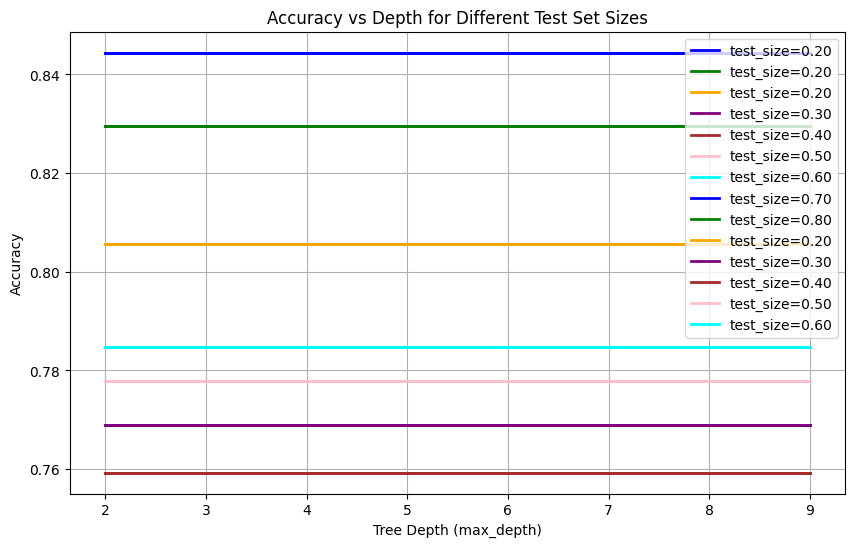

In [28]:
#plot accuracy vs max_depth for different test_size values (all in the same plot, drawing a line for each different size)
x_axis = list(range(min_depth, max_depth))
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']
plt.figure(figsize=(10,6))
#enumerate(accuracy_list_list): enumerate è una funzione che restituisce sia l'indice dell'elemento (i) che l'elemento stesso (acc_list) durante l'iterazione. In altre parole:
#i: è l'indice che tiene traccia di quale elemento della lista accuracy_list_list stai considerando in questo momento. È utile per associare ciascuna lista di accuratezze al valore corrispondente di test_size, che si trova in size_list[i].
#acc_list: è la lista delle accuratezze per un particolare valore di test_size, quindi quando iteri su accuracy_list_list, per ogni valore di i otterrai una lista di accuracies corrispondenti a un particolare test_size.
#In ogni iterazione, utilizzi i per accedere al valore di test_size corrispondente nella lista size_list, e acc_list per tracciare la curva di accuratezza rispetto alla profondità dell'albero (x_axis
#colors[i % len(colors)] fa sì che, se ci sono più di 7 valori di test_size, i colori vengano ripetuti ciclicamente
# Add to plot all the  entries in accuracy_list_list
for i, acc_list in enumerate(accuracy_list_list):
    plt.plot(x_axis, acc_list, color=colors[i % len(colors)],
             label=f"test_size={size_list[i]:.2f}", linewidth=2)

# Personalize the plot
plt.xlabel("Tree Depth (max_depth)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Depth for Different Test Set Sizes")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Solution 3.c

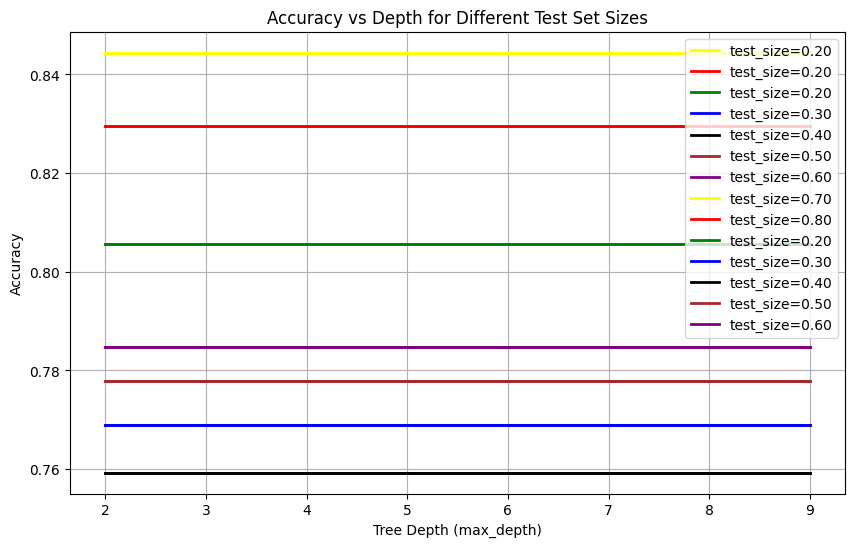

In [27]:
# Create the plot
x_axis = list(range(min_depth, max_depth))
colors = ["yellow", "red", "green", "blue", "black", "brown", "purple"]

plt.figure(figsize=(10,6))

# Add to plot all the  entries in accuracy_list_list
for i, acc_list in enumerate(accuracy_list_list):
    plt.plot(x_axis, acc_list, color=colors[i % len(colors)],
             label=f"test_size={size_list[i]:.2f}", linewidth=2)

# Personalize the plot
plt.xlabel("Tree Depth (max_depth)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Depth for Different Test Set Sizes")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

*Plot Comment: max_depth vs test_size*:
- This plot shows the average accuracy values obtained for different combinations of `max_depth` (maximum tree depth) and `test_size` (portion of data reserved for testing).
- Accuracy increases quickly up to depth 3, then stabilizes or fluctuates slightly.
